In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from math import cos, sin ,pi

In [8]:
# В - 15
def func(x: float, deriv_s: int = 0):
    """
    Функция y = 2x− cos(x)

    При вводе аргумента deriv_s можно выбрать степень производной

    :param x: Точка
    :param deriv_s: Степень производной

    :return: Значение функции в точке x
    :rtype: float

    """
    if deriv_s == 0:
        return 2 * x - cos(x)
    elif deriv_s == 1:
        return 2 + sin(x)
    return cos(x + ((deriv_s - 2) * pi) / 2)


a, b = 0.1, 0.6

In [9]:
def get_moments(x_coords: list[float], y_coords: list[float]) -> list[float]:
    """
    Вычисление моментов через обратный ход метода прогонки (с конца)
    """
    count_diap = len(x_coords) - 1
    moments = [func(b, 2)] # Моменты со 2-м краевым условием
    result_list = [func(a, 2)] \
    + [6 * ((y_coords[i + 1] - y_coords[i]) / (x_coords[i + 1] - x_coords[i]) - (y_coords[i] - y_coords[i - 1]) / (x_coords[i] - x_coords[i - 1])) \
       / (x_coords[i + 1] - x_coords[i - 1]) for i in range(1, count_diap)] \
    + [func(b, 2)] # F_i
    matrix = [[0, 1, 0]] \
    + [[(x_coords[i + 1] - x_coords[i]) / (x_coords[i + 1] - x_coords[i - 1]), 2,
        (x_coords[i] - x_coords[i - 1]) / (x_coords[i + 1] - x_coords[i - 1])] 
        for i in range(1, count_diap)] \
    + [[0, 1, 0]] # Матрица

    alpha, beta = [-matrix[0][2] / matrix[0][1]], [result_list[0] / matrix[0][1]] # Коэффициенты
    for i in range(count_diap - 1):
        alpha.append(-matrix[i][2] / (alpha[i] * matrix[i][0] + matrix[i][1]))
        beta.append((result_list[i] - beta[i] * matrix[i][0]) / (alpha[i] * matrix[i][0] + matrix[i][1]))
    
    for i in range(count_diap - 1, 0, -1):
        moments.append(alpha[i] * moments[count_diap - i - 1] + beta[i]) # Моменты по формуле прогонки

    moments.append(func(a, 2)) # Второе краевое условие
    moments.reverse()
    return moments


def get_moment_cubic_splines(moments: list[float], x_coords: list[float], y_coords: list[float]):
    """
    Вычисление коэффициентов кубического сплайна через найденные моменты 
    """
    count_diap = len(x_coords) - 1
    parameters = []
    for i in range(count_diap):
        parameters.append(
            [
                (moments[i + 1] - moments[i]) / (x_coords[i + 1] - x_coords[i]), 
                moments[i],
                (y_coords[i + 1] - y_coords[i]) / (x_coords[i + 1] - x_coords[i]) \
                - (x_coords[i + 1] - x_coords[i]) * (2 * moments[i] + moments[i + 1]) / 6,
                y_coords[i]
            ]
        )
    
    return parameters


In [10]:
ns = [n for n in range(2,100 + 1)]
maxf = max(abs(func(a + i*(b - a)/999)) for i in range(1000))
delta_f = []
relative_f = []
# Для каждого n вычисляем абсолютную и относительную ошибку сплайна 
for n in ns:
    maxs = 0
    x = [a + i*(b - a)/n for i in range(n + 1)]
    y = [func(x[i]) for i in range(n + 1)]

    M = get_moments(x, y)
    params = get_moment_cubic_splines(M, x, y)
    for i in range(n):
        subx = [x[i] + j*(x[i + 1] - x[i])/9 for j in range(10)]
        suby = [(subx[j] - x[i])**3 * params[i][0]/6 \
                        + (subx[j] - x[i])**2 * params[i][1]/2 \
                        + (subx[j] - x[i]) * params[i][2] \
                        + params[i][3] 
                        for j in range(10)]
        maxsn = max(abs(func(subx[j]) - suby[j]) for j in range(10)) 
        maxs = maxs if maxs > maxsn else maxsn

    delta_f.append(maxs)
    relative_f.append(maxs / maxf * 100)


pd.DataFrame({"n": ns, "delta f_n": delta_f, "relative f_n, %": relative_f})

,n,delta f_n,"relative f_n, %"
0,2,1.780491e-04,0.022396
1,3,1.848194e-04,0.023248
2,4,9.609730e-05,0.012088
3,5,5.482595e-05,0.006896
4,6,3.397079e-05,0.004273
...,...,...,...
94,96,1.072281e-08,0.000001
95,97,1.039613e-08,0.000001
96,98,1.008258e-08,0.000001
97,99,9.781516e-09,0.000001


Text(0.5, 1.0, 'График зависимости абсолютной ошибки от n')

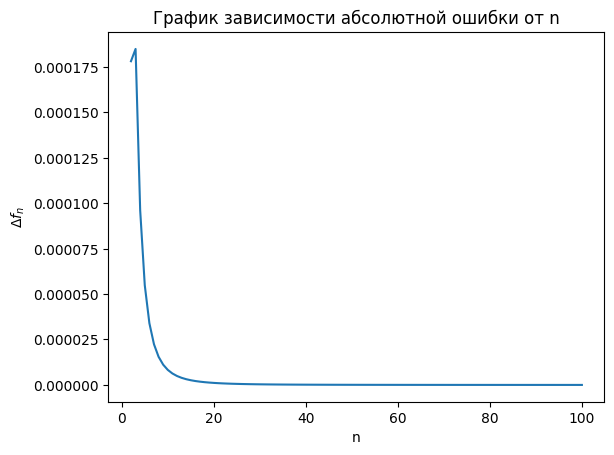

In [11]:
plt.plot(ns, delta_f)
plt.xlabel('n')
plt.ylabel("$\Delta f_n$")
plt.title("График зависимости абсолютной ошибки от n")

In [12]:
n = 5
fl = [6, 8, 3, 6, 2, 6 - 14/9]
matrix = [[0, 9, 9], [7, 11, 4], [7, 1, -6], [-10, 20, -10], 
          [-9, 5, 4], [0, 9 - 35/9, 3 - 28/9]]

alpha, beta = [-matrix[0][2] / matrix[0][1]], [fl[0] / matrix[0][1]]
for i in range(n - 1):
    alpha.append(-matrix[i][2] / (alpha[i] * matrix[i][0] + matrix[i][1]))
    beta.append((fl[i] - beta[i] * matrix[i][0]) / (alpha[i] * matrix[i][0] + matrix[i][1]))

print(alpha)
print(beta)

M = [(fl[n] - beta[n - 1]*matrix[n][0]) / (matrix[n][1] + alpha[n - 1]*matrix[n][0])]
for i in range(n - 1, -1, -1):
    M.append(alpha[i] * M[n - i - 1] + beta[i])


M.reverse()
print(sum(M))
M

[-1.0, -1.0, -1.0, -1.0, 0.3333333333333333]
[0.6666666666666666, 0.6666666666666666, 0.8333333333333335, 0.4722222222222223, 0.35740740740740745]
3.01682769726248


[1.0083735909822868,
 -0.3417069243156202,
 1.0083735909822868,
 -0.17504025764895326,
 0.6472624798711756,
 0.8695652173913044]